# Setup

## Installs

In [ ]:
# Segmentation
# ! pip install --upgrade mxnet
# ! pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install --upgrade gluoncv

In [ ]:
# Edge detection
# ! conda install scikit-image

In [ ]:
# Depth estimation
# ! pip install -q transformers

## Imports

In [ ]:
# Segmentation
import numpy as np

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils.viz import get_color_pallete
from gluoncv.data.transforms.presets.segmentation import test_transform

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import PIL.Image as pil

# using cpu
ctx = mx.cpu(0)

In [ ]:
# Edge detection
from skimage.feature import canny
from matplotlib import cm

In [ ]:
# Depth estimation
from transformers import pipeline
import requests

# Read and Transform File

In [ ]:
filename = 'images/inputs/rooms/empty-room.png'

In [ ]:
img = image.imread(filename)
plt.imshow(img.asnumpy())
plt.show()

In [ ]:
img_t = test_transform(img, ctx)
img_t.shape

# Semantic Segmentation

In [ ]:
semantic_seg_model_psp = model = gluoncv.model_zoo.get_model('psp_resnet101_ade', pretrained=True)
semantic_seg_model_deeplab =gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True)
semantic_seg_model_fcn = gluoncv.model_zoo.get_model('fcn_resnet101_voc', pretrained=True)

In [ ]:
output = semantic_seg_model_psp.predict(img_t)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'ade20k')
mask.save('images/outputs/segmentation-output.png')

In [ ]:
mmask = mpimg.imread('images/outputs/segmentation-output.png')
plt.imshow(mmask)
plt.show()

### Isolate walls

In [ ]:
labs = []

for i in range(mmask.shape[0]):
    row = []
    for j in range(mmask.shape[1]):
        row.append(",".join(mmask[i, j].astype(str)))
    labs.append(row)

labs = np.array(labs)
labs.shape

In [ ]:
ind_0, ind_1 = np.where(labs != "0.47058824,0.47058824,0.47058824,1.0")
ind_2, ind_3 = np.where(labs == "0.47058824,0.47058824,0.47058824,1.0")

# Edge Detection

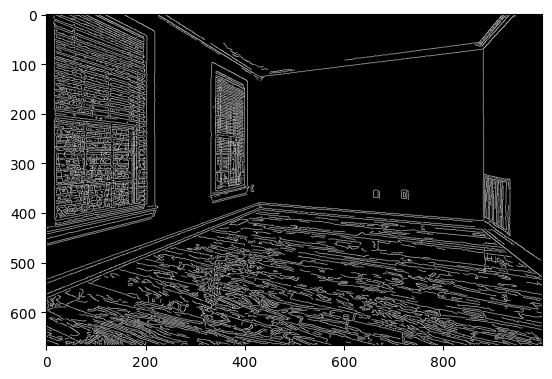

In [57]:
import cv2
import PIL.Image as pil
from matplotlib import pyplot as plt
from matplotlib import cm

# Read image
image = cv2.imread('../images/inputs/rooms/real/empty6.jpg')

# Convert image to grayscale
blur = cv2.blur(image, (3, 3))
gray = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
 
# Use canny edge detection
edges = cv2.Canny(gray, 15, 30, apertureSize=3)

edge_map = pil.fromarray(edges)
edge_map.save('../images/outputs/edge-detection-output.png')

plt.imshow(edge_map, cmap=cm.gray)
plt.show()

# Combining Images

In [ ]:
# Combine edge map and segmentation map
edge_map_array = np.asarray(edge_map.convert('RGB'))
segmented_edges = np.empty( (edge_map_array.shape[0], edge_map_array.shape[1], 3) )
segmented_edges[:] = np.nan
segmented_edges[ind_2, ind_3] = edge_map_array[ind_2, ind_3]
plt.imshow(segmented_edges)
segmented_edges = segmented_edges.astype(dtype=np.uint8)

segmented_edges = pil.fromarray(segmented_edges)
segmented_edges.save('images/outputs/segmented-edges.png')
# plt.imshow(edge_map)

In [ ]:
im = cv2.imread('images/outputs/segmented-edges.png')
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, edge_thresh = cv2.threshold(imgray, 0, 1, 0)

# thresh = cv.adaptiveThreshold(imgray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 3, 1)

# kernel = cv.getStructuringElement(cv.MORPH_RECT,(10, 10))
# thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN,kernel)
edge_contours, _ = cv2.findContours(edge_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(edge_thresh)

In [ ]:
# https://stackoverflow.com/questions/44127342/detect-card-minarea-quadrilateral-from-contour-opencv?
# fbclid=IwAR3A4AjuD7x8dp07ln4sPJYFyMR1m_u1sb-m1hAbdzc9epuyZcCh5yaij8Y

im_2 = np.zeros( (im.shape[0], im.shape[1], 3) )

final_cnt = []

for cnt in edge_contours:
    x1,y1 = cnt[0][0]

    if cv2.arcLength(cnt,True) > 200:
        im_2 = cv2.drawContours(im_2, [cnt], -1, (0,0,255), 2)

plt.imshow(im_2)
final_cnt = np.array(final_cnt)

im_2 = pil.fromarray(im_2.astype(dtype=np.uint8))
im_2.save('images/outputs/contours.png')

In [ ]:
# Hough transform on segmented edges

# Read image
test = np.asarray(segmented_edges)
blank_image = np.empty( (test.shape[0], test.shape[1], 3) )
test = cv2.imread('images/outputs/segmented-edges.png')
test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

# Apply HoughLinesP method to 
# to directly obtain line end points
lines_list =[]
lines = cv2.HoughLinesP(
            test, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=50, # Min number of votes for valid line
            minLineLength=45, # Min allowed length of line
            maxLineGap=20 # Max allowed gap between line for joining them
            )
 
# Iterate over points
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    # Draw the lines joing the points
    # On the original image
    cv2.line(blank_image,(x1,y1),(x2,y2),(0,0,255),2)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1),(x2,y2)])
     
# Save the result image
cv2.imwrite('images/outputs/hough-output.png',blank_image)
plt.imshow(blank_image)

In [ ]:
# https://www.youtube.com/watch?v=veoz_46gOkc
hough_img = cv2.imread('images/outputs/hough-output.png')
kernel = np.ones((20,1), np.uint8)
vertical_lines = cv2.erode(hough_img, kernel, iterations=1)
cv2.imwrite('images/outputs/vertical-hough-ouput.png',vertical_lines)

plt.imshow(vertical_lines)
plt.show()

## Finding Geometry

##### Extracting Geometry

In [ ]:
im = cv2.imread('images/outputs/contours.png')
assert im is not None, "file could not be read, check with os.path.exists()"
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0, 1, 0)

# thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
im_2 = im.copy()
final_cnt = []

for cnt in contours:
    x1,y1 = cnt[0][0]
    approx = cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt, True), False)

    # cv.putText(im_2, 'Rectangle', (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    im_2 = cv2.drawContours(im_2, [cnt], -1, (0,0,255), 3)
    plt.scatter(approx[:, 0, 0], approx[:, 0, 1], color="r")
    final_cnt.append(approx[:, 0, :])
    
plt.imshow(im_2)
final_cnt = np.array(final_cnt)

In [ ]:
for i in range(len(final_cnt)):
    data = np.append(final_cnt[i], final_cnt[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])

corner_inds = [118, 442]
plt.scatter(corner_inds, [-150, -150])

In [ ]:
corner_adj_geom = []

for i in range(len(final_cnt)):
    data = np.array(final_cnt[i])[:, 0]
    limit = 5
    
    diff_1 = np.sum(np.abs(data.copy() - corner_inds[0]) <= limit)
    diff_2 = np.sum(np.abs(data.copy() - corner_inds[1]) <= limit)
    
    if diff_1 >= 2 or diff_2 >= 2:
        corner_adj_geom.append(final_cnt[i])
        
for i in range(len(corner_adj_geom)):
    data = np.append(corner_adj_geom[i], corner_adj_geom[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])